In [9]:
mse <- function(y, yhat) mean((y - yhat)^2)
#install.packages(c('glmnet','gglasso','genlasso','pls','Matrix','imager'))

# Generating data
Data_generation <- function(n = 200, p = 20, s = 7, sigma = 1, seed = 1) {
  set.seed(seed)
  # Sets the seed for random number generation. This ensures that if you run
  # the function with the same seed, you will get the exact same simulated data
  # each time.

  X <- matrix(rnorm(n * p), n, p)

  beta_vec <- rep(0, p) #true beta

  beta_vec[1:s] <- seq(from = 2, length.out = s, by = -0.3)
  # This means only the first 's' predictors in X will have a non-zero effect on y.

  y <- X %*% beta_vec + rnorm(n, sd = sigma)
  # The error is added to the linear combination to get the final response 'y'.

  list(X = X, y = as.numeric(y), beta = beta_vec)
  # Returns a list containing the generated data and the true coefficients:
  # X: the predictor matrix
  # y: the response vector (converted to a numeric vector using as.numeric)
  # beta: the true coefficient vector
}

Data_generation_grouped <- function(n = 200,
                                    n_groups = 20,
                                    group_size = 3,
                                    n_active = 5,
                                    coef_mag = function(k) seq(from = 2, length.out = k, by = -0.3),
                                    sigma = 1,
                                    seed = 1) {
  set.seed(seed)
  # Build group sizes
  if (length(group_size) == 1) {
    group_size <- rep(group_size, n_groups)
  } else {
    if (length(group_size) != n_groups) stop("group_size length must equal n_groups")
  }
  p <- sum(group_size)
  # design matrix
  X <- matrix(rnorm(n * p), nrow = n, ncol = p)
  # groups vector: length p, values 1..n_groups
  groups <- rep(seq_len(n_groups), times = group_size)
  # true beta: group-sparse
  beta <- rep(0, p)
  active_groups <- sample(seq_len(n_groups), n_active)
  # assign coefficients within each active group
  for (g in active_groups) {
    idxs <- which(groups == g)
    k <- length(idxs)
    if (is.function(coef_mag)) {
      vals <- coef_mag(k)
      # if returned length differs, recycle/truncate
      vals <- rep(vals, length.out = k)
    } else if (length(coef_mag) == 1) {
      vals <- rep(coef_mag, k)
    } else {
      vals <- rep(coef_mag, length.out = k)
    }
    beta[idxs] <- vals
  }
  # response
  y <- as.numeric(X %*% beta + rnorm(n, sd = sigma))
  list(X = X, y = y, beta = beta, groups = groups, active_groups = active_groups)
}

In [ ]:
# -------------------- LASSO via glmnet -----------------------------
# Uses glmnet and cv.glmnet to select lambda
lasso_glmnet <- function(X, y, nfolds = 5, alpha = 1) {
  if (!requireNamespace('glmnet', quietly = TRUE)) stop('Install package glmnet')
  library(glmnet)
  # glmnet expects x as matrix, y as vector
  cvfit <- cv.glmnet(x = X, y = y, alpha = alpha, nfolds = nfolds, standardize = TRUE)
  lambda_min <- cvfit$lambda.min
  coef_vec <- as.numeric(coef(cvfit, s = "lambda.min")) # includes intercept at index 1
  intercept <- coef_vec[1]
  beta <- coef_vec[-1]
  list(cvfit = cvfit, lambda_min = lambda_min, intercept = intercept, beta = beta,summary=summary(cvfit))
}

predict_lasso_glmnet <- function(fit, Xnew) {
  predict(fit$cvfit, newx = Xnew, s = "lambda.min")
}

L=Data_generation(n=1000)
Scaled_X=scale(L$X, center = TRUE, scale = TRUE)

model=lasso_glmnet(X=Scaled_X,y=L$y)

cat("Estimated beta: ",model$beta,"\n")
cat("True beta: ", L$beta,"\n")
cat("MSE: ",mse(predict_lasso_glmnet(model,Scaled_X),L$y))

Estimated beta:  2.052607 1.727688 1.45237 1.055687 0.836163 0.4885604 0.2063892 0 0 -0.00952182 0 0.01161238 0 -0.007102624 0 0 0 0.01959106 0 -0.02797364 
True beta:  2 1.7 1.4 1.1 0.8 0.5 0.2 0 0 0 0 0 0 0 0 0 0 0 0 0 
MSE:  1.012008

In [11]:
###############################################################################
# Group LASSO (gglasso) demo — shows number of true vs selected active groups
###############################################################################

# -------------------- Group LASSO via gglasso --------------------
group_lasso_gglasso <- function(X, y, groups, nfolds = 5) {
  if (!requireNamespace("gglasso", quietly = TRUE)) install.packages("gglasso")
  library(gglasso)
  stopifnot(length(groups) == ncol(X))
  
  n <- nrow(X)
  if (nfolds >= n) {
    nfolds <- max(2, n)
    message("Adjusted nfolds to ", nfolds)
  }
  
  x_scaled <- scale(X, center = TRUE, scale = TRUE)
  cvfit <- cv.gglasso(x = x_scaled, y = y, group = groups, loss = "ls", nfolds = nfolds)
  lambda_min <- cvfit$lambda.min
  
  beta_full <- coef(cvfit, s = "lambda.min")
  intercept <- as.numeric(beta_full[1])
  beta <- as.numeric(beta_full[-1])
  
  y_hat <- as.numeric(predict(cvfit, x_scaled, s = "lambda.min"))
  
  list(cvfit = cvfit,
       lambda_min = lambda_min,
       intercept = intercept,
       beta = beta,
       mse = mse(y, y_hat))
}

example_group_lasso <- function(dat, nfolds = 5, tol = 1e-8) {
  res <- group_lasso_gglasso(dat$X, dat$y, groups = dat$groups, nfolds = nfolds)
  
  uniqg <- sort(unique(dat$groups))
  nz_groups <- sapply(uniqg, function(g) any(abs(res$beta[dat$groups == g]) > tol))
  selected_groups <- uniqg[nz_groups]
  
  cat("\n===== Group LASSO Summary =====\n")
  cat("Lambda chosen:", res$lambda_min, "\n")
  cat("Training MSE:", res$mse, "\n\n")
  
  cat("True active groups:     ", dat$active_groups, "\n")
  cat("Selected active groups: ", selected_groups, "\n\n")
  cat("Number of true active groups:     ", length(dat$active_groups), "\n")
  cat("Number of groups selected by model:", length(selected_groups), "\n")
  cat("Overlap (true ∩ selected):        ", sum(selected_groups %in% dat$active_groups), "\n")
  
}

dat <- Data_generation_grouped(
  n = 10000,          # sample size
  n_groups = 20,    # total groups
  group_size = 2,   # vars per group
  n_active = 5,     # number of truly active groups
  sigma = 1,
  seed = 14,
)

out <- example_group_lasso(dat, nfolds = 5)


===== Group LASSO Summary =====
Lambda chosen: 0.009263274 
Training MSE: 0.9836723 

True active groups:      1 12 5 20 19 
Selected active groups:  1 3 5 10 12 14 17 19 20 

Number of true active groups:      5 
Number of groups selected by model: 9 
Overlap (true ∩ selected):         5 


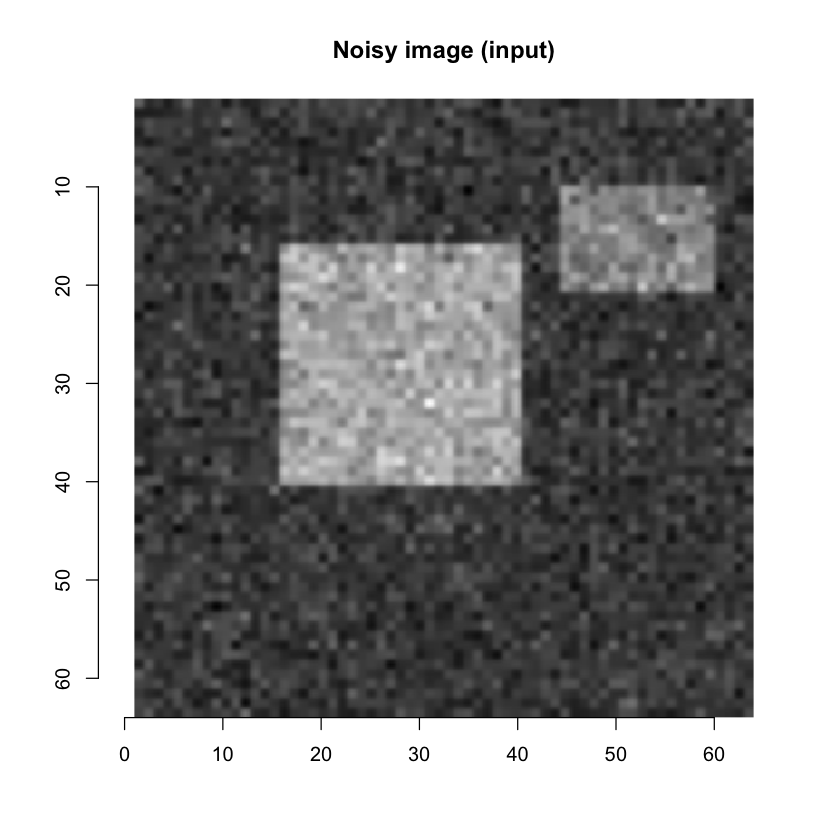

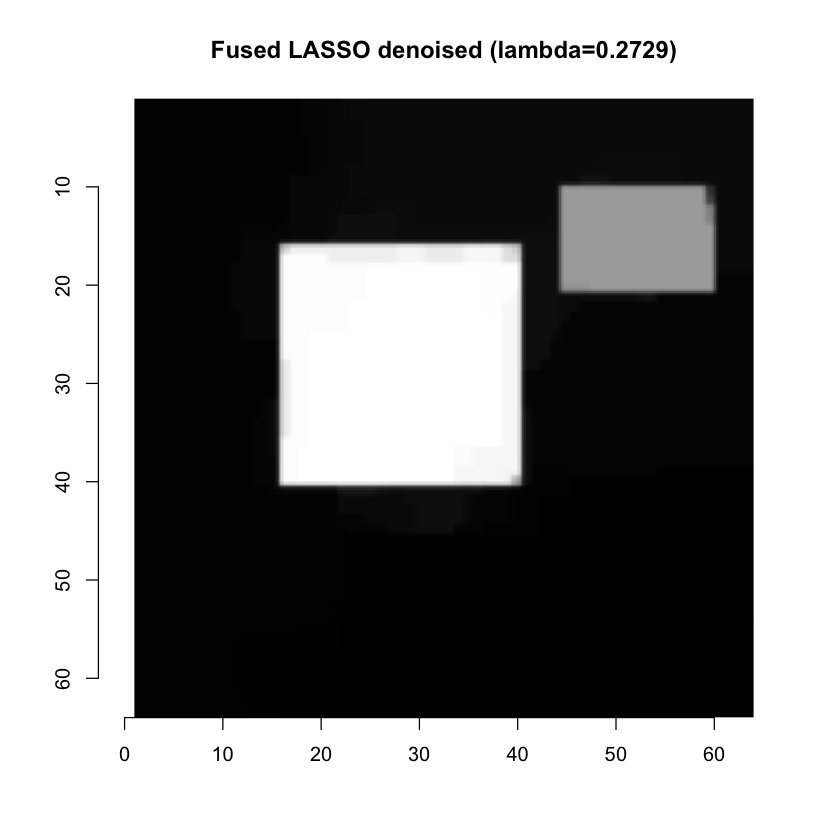

In [12]:
# -------------------- Fused LASSO on 2D image using genlasso -------
# We will use genlasso::fusedlasso with a difference matrix D constructed for 2D.
# This solves: minimize 0.5||y - x||_2^2 + lambda ||D x||_1

build_diff_ops_sparse <- function(nr, nc) {
  if (!requireNamespace('Matrix', quietly = TRUE)) stop('Install package Matrix')
  library(Matrix)
  N <- nr * nc
  # horizontal differences
  rows_h <- c(); cols_h <- c(); vals_h <- c(); rcount <- 1
  for (i in 1:nr) {
    for (j in 1:(nc - 1)) {
      idx <- (j - 1) * nr + i
      idx2 <- j * nr + i
      rows_h <- c(rows_h, rcount, rcount)
      cols_h <- c(cols_h, idx, idx2)
      vals_h <- c(vals_h, -1, 1)
      rcount <- rcount + 1
    }
  }
  Dh <- sparseMatrix(i = rows_h, j = cols_h, x = vals_h, dims = c(nr * (nc - 1), N))
  # vertical differences
  rows_v <- c(); cols_v <- c(); vals_v <- c(); rcount <- 1
  for (j in 1:nc) {
    for (i in 1:(nr - 1)) {
      idx <- (j - 1) * nr + i
      idx2 <- (j - 1) * nr + i + 1
      rows_v <- c(rows_v, rcount, rcount)
      cols_v <- c(cols_v, idx, idx2)
      vals_v <- c(vals_v, -1, 1)
      rcount <- rcount + 1
    }
  }
  Dv <- sparseMatrix(i = rows_v, j = cols_v, x = vals_v, dims = c((nr - 1) * nc, N))
  D <- rbind(Dh, Dv)
  D
}

fused_lasso_genlasso <- function(y_image, lambda = 0, nlambda = 50) {
  if (!requireNamespace('genlasso', quietly = TRUE)) stop('Install package genlasso')
  library(genlasso)
  nr <- nrow(y_image); nc <- ncol(y_image); N <- nr * nc
  y_vec <- as.numeric(y_image)
  D <- build_diff_ops_sparse(nr, nc)
  # genlasso::fusedlasso accepts y and D (and optionally X)
  # We will compute solution path and let user pick lambda or pick by heuristic
  fit <- genlasso::fusedlasso(y = y_vec, D = D, minlam = 0)
  # fusedlasso returns path; if lambda provided, interpolate; else pick moderate index
  if (!is.null(lambda)) {
    # find index with closest lambda
    idx <- which.min(abs(fit$lambda - lambda))
  } else {
    # pick median lambda index (heuristic)
    idx <- ceiling(length(fit$lambda) / 3)
  }
  x_hat <- fit$beta[, idx]
  x_img <- matrix(x_hat, nrow = nr, ncol = nc)
  list(fit = fit, idx = idx, x = x_hat, x_img = x_img, lambda_used = fit$lambda[idx])
}

import_image_gray <- function(path, target_dim = NULL) {
  if (!requireNamespace('imager', quietly = TRUE)) stop('Please install package imager')
  library(imager)
  img <- load.image(path)
  imgg <- grayscale(img)
  # resize if requested
  if (!is.null(target_dim)) imgg <- imager::imresize(imgg, size = target_dim)
  mat <- t(as.matrix(imgg))
  mat
}

example_fused_lasso <- function(simulate = TRUE, img_path = NULL, nr = 64, nc = 64, lambda = 0) {
  if (simulate) {
    # synthetic piecewise constant image + noise
    img <- matrix(0, nr, nc)
    img[16:40, 16:40] <- 1
    img[10:20, 45:60] <- 0.7
    noisy <- img + matrix(rnorm(nr * nc, sd = 0.2), nr, nc)
    y <- noisy
  } else {
    if (is.null(img_path)) stop('Provide img_path when simulate = FALSE')
    y <- import_image_gray(img_path, target_dim = c(nr, nc))
  }
  res <- fused_lasso_genlasso(y, lambda = lambda)
  # display if imager available
  if (requireNamespace('imager', quietly = TRUE)) {
    library(imager)
    plot(as.cimg(t(y)), main = 'Noisy image (input)')
    plot(as.cimg(t(res$x_img)), main = sprintf('Fused LASSO denoised (lambda=%.4g)', res$lambda_used))
  }
  invisible(list(y = y, denoised = res$x_img, res = res))
}

model=example_fused_lasso(simulate = TRUE)

Training MSE: 1.235423 
Proportion of predictor variance explained by 9 PC(s): 0.9094 



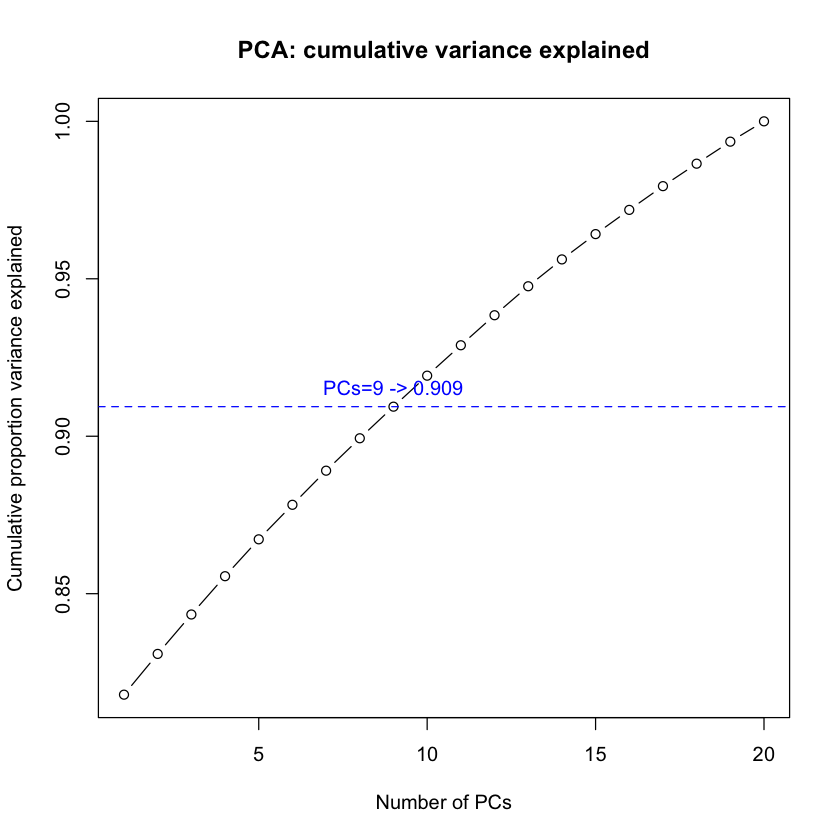

In [ ]:
# -------------------- Principal Component Regression --------------
# Uses pls::pcr which has internal cross-validation
Data_generation <- function(n = 200, p = 20, s = 7, sigma = 1, seed = 1, rho = 0.8) {
  # rho = correlation between predictors (0 = independent, 1 = perfectly collinear)
  set.seed(seed)

  # Step 1: Build a correlation (covariance) matrix
  Sigma <- matrix(rho, nrow = p, ncol = p)  # common correlation
  diag(Sigma) <- 1

  # Step 2: Make column variances unequal
  col_sds <- exp(seq(log(0.5), log(2.5), length.out = p))  # geometric sequence of std devs
  Sigma <- diag(col_sds) %*% Sigma %*% diag(col_sds)       # apply unequal variances

  # Step 3: Generate correlated predictors
  L <- chol(Sigma)                       # Cholesky decomposition
  Z <- matrix(rnorm(n * p), n, p)        # independent standard normals
  X <- Z %*% L                           # correlated, scaled predictors

  # Step 4: Define true coefficients (same pattern)
  beta_vec <- rep(0, p)
  beta_vec[1:s] <- seq(from = 2, length.out = s, by = -0.3)

  # Step 5: Generate response with noise
  y <- as.numeric(X %*% beta_vec + rnorm(n, sd = sigma))

  list(X = X, y = y, beta = beta_vec, col_sds = col_sds, rho = rho)
}
pcr_example <- function(X, y, ncomp = 10, validation = "CV") {
  if (!requireNamespace('pls', quietly = TRUE)) stop('Install package pls')
  library(pls)
  # prepare data.frame: use a named response so formula works cleanly
  df <- as.data.frame(X)
  df$.y_for_pcr <- as.numeric(y)

  # center & scale performed inside pcr if scale = TRUE
  fit <- pcr(.y_for_pcr ~ ., ncomp = ncomp, data = df, scale = TRUE, validation = validation)

  # choose ncomp by CV
  cv <- RMSEP(fit)
  rm_vals <- as.numeric(cv$val[1,1, ])   # RMSEP for 0..ncomp
  # pick minimum CV (ignoring "adj" components if present)
  ncomp_opt <- which.min(rm_vals) - 1 # RMSEP returns with 0 comps at index 1
  if (ncomp_opt < 1) ncomp_opt <- 1

  # --- proportion variance explained in X by first ncomp_opt PCs (scale matches pcr)
  pc <- prcomp(X, center = TRUE, scale. = TRUE)
  var_explained <- (pc$sdev^2) / sum(pc$sdev^2)       # proportion per PC
  cum_var_expl <- cumsum(var_explained)               # cumulative
  prop_var_explained <- cum_var_expl[ncomp_opt]       # proportion explained by chosen PCs

  list(fit = fit,
       ncomp_opt = ncomp_opt,
       rm_vals = rm_vals,
       prop_var_explained = prop_var_explained,
       var_explained = var_explained,
       cum_var_expl = cum_var_expl)
}

pcr_predict <- function(pcr_obj, Xnew) {
  preds <- predict(pcr_obj$fit, newdata = as.data.frame(Xnew), ncomp = pcr_obj$ncomp_opt)
  as.numeric(preds)
}

if (!exists("Data_generation")) {
  Data_generation <- function(n = 200, p = 20, s = 7, sigma = 1, seed = 1) {
    set.seed(seed)
    X <- matrix(rnorm(n * p), n, p)
    beta <- rep(0, p)
    beta[1:s] <- seq(from = 2, length.out = s, by = -0.3)
    y <- as.numeric(X %*% beta + rnorm(n, sd = sigma))
    list(X = X, y = y, beta = beta)
  }
}

dat <- Data_generation(n=500, p=20, s=8, sigma=1, seed=7)
model_pcr <- pcr_example(dat$X, dat$y, ncomp = 9, validation = "CV")
yhat <- pcr_predict(model_pcr, dat$X)
mse_pcr <- mse(yhat, dat$y)

cat("Training MSE:", round(mse_pcr, 6), "\n")
cat("Proportion of predictor variance explained by", model_pcr$ncomp_opt, "PC(s):",
    round(model_pcr$prop_var_explained, 4), "\n\n")

# cumulative variance explained plot
op <- par(no.readonly = TRUE)
par(mfrow = c(1,1))
plot(seq_along(model_pcr$cum_var_expl), model_pcr$cum_var_expl, type = "b",
     xlab = "Number of PCs", ylab = "Cumulative proportion variance explained",
     main = "PCA: cumulative variance explained")
abline(h = model_pcr$prop_var_explained, col = "blue", lty = 2)
text(model_pcr$ncomp_opt, model_pcr$prop_var_explained,
     labels = paste0("PCs=", model_pcr$ncomp_opt, " -> ", round(model_pcr$prop_var_explained,3)),
     pos = 3, col = "blue")
par(op)

In [ ]:
col = p)  # common correlation
  diag(Sigma) <- 1

  # Step 2: Make column variances unequal
  col_sds <- exp(seq(log(0.5), log(2.5), length.out = p))  # geometric sequence of std devs
  Sigma <- diag(col_sds) %*% Sigma %*% diag(col_sds)       # apply unequal variances

  # Step 3: Generate correlated predictors
  L <- chol(Sigma)                       # Cholesky decomposition
  Z <- matrix(rnorm(n * p), n, p)        # independent standard normals
  X <- Z %*% L                           # correlated, scaled predictors

  # Step 4: Define true coefficients (same pattern)
  beta_vec <- rep(0, p)
  beta_vec[1:s] <- seq(from = 2, length.out = s, by = -0.3)

  # Step 5: Generate response with noise
  y <- as.numeric(X %*% beta_vec + rnorm(n, sd = sigma))

  list(X = X, y = y, beta = beta_vec, col_sds = col_sds, rho = rho)
}
pcr_example <- function(X, y, ncomp = 10, validation = "CV") {
  if (!requireNamespace('pls', quietly = TRUE)) stop('Install package pls')
  library(pls)
  # prepare data.frame: use a named response so formula works cleanly
  df <- as.data.frame(X)
  df$.y_for_pcr <- as.numeric(y)

  # center & scale performed inside pcr if scale = TRUE
  fit <- pcr(.y_for_pcr ~ ., ncomp = ncomp, data = df, scale = TRUE, validation = validation)

  # choose ncomp by CV
  cv <- RMSEP(fit)
  rm_vals <- as.numeric(cv$val[1,1, ])   # RMSEP for 0..ncomp
  # pick minimum CV (ignoring "adj" components if present)
  ncomp_opt <- which.min(rm_vals) - 1 # RMSEP returns with 0 comps at index 1
  if (ncomp_opt < 1) ncomp_opt <- 1

  # --- proportion variance explained in X by first ncomp_opt PCs (scale matches pcr)
  pc <- prcomp(X, center = TRUE, scale. = TRUE)
  var_explained <- (pc$sdev^2) / sum(pc$sdev^2)       # proportion per PC
  cum_var_expl <- cumsum(var_explained)               # cumulative
  prop_var_explained <- cum_var_expl[ncomp_opt]       # proportion explained by chosen PCs

  list(fit = fit,
       ncomp_opt = ncomp_opt,
       rm_vals = rm_vals,
       prop_var_explained = prop_var_explained,
       var_explained = var_explained,
       cum_var_expl = cum_var_expl)
}

pcr_predict <- function(pcr_obj, Xnew) {
  preds <- predict(pcr_obj$fit, newdata = as.data.frame(Xnew), ncomp = pcr_obj$ncomp_opt)
  as.numeric(preds)
}

if (!exists("Data_generation")) {
  Data_generation <- function(n = 200, p = 20, s = 7, sigma = 1, seed = 1) {
    set.seed(seed)
    X <- matrix(rnorm(n * p), n, p)
    beta <- rep(0, p)
    beta[1:s] <- seq(from = 2, length.out = s, by = -0.3)
    y <- as.numeric(X %*% beta + rnorm(n, sd = sigma))
    list(X = X, y = y, beta = beta)
  }
}

dat <- Data_generation(n=500, p=20, s=8, sigma=1, seed=7)
model_pcr <- pcr_example(dat$X, dat$y, ncomp = 9, validation = "CV")
yhat <- pcr_predict(model_pcr, dat$X)
mse_pcr <- mse(yhat, dat$y)

cat("Training MSE:", round(mse_pcr, 6), "\n")
cat("Proportion of predictor variance explained by", model_pcr$ncomp_opt, "PC(s):",
    round(model_pcr$prop_var_explained, 4), "\n\n")

# cumulative variance explained plot
op <- par(no.readonly = TRUE)
par(mfrow = c(1,1))
plot(seq_along(model_pcr$cum_var_expl), model_pcr$cum_var_expl, type = "b",
     xlab = "Number of PCs", ylab = "Cumulative proportion variance explained",
     main = "PCA: cumulative variance explained")
abline(h = model_pcr$prop_var_explained, col = "blue", lty = 2)
text(model_pcr$ncomp_opt, model_pcr$prop_var_explained,
     labels = paste0("PCs=", model_pcr$ncomp_opt, " -> ", round(model_pcr$prop_var_explained,3)),
     pos = 3, col = "blue")
par(op)